[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ThomasAlbin/Astroniz-YT-Tutorials/blob/main/[ML1]-Asteroid-Spectra/9_dl_convnet_multiclass.ipynb)

# Step 9: Deep Learning - A Convolutional Approach

This time, we are re-using our code from last time (session #8) and replace your model creation function with a convolutional neural network. Let's see who the architecture changes and whether we obtain better results than last time.

Further, we are preparing our data a little bit differently.

In [1]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd

import sklearn
from sklearn import preprocessing

In [2]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [3]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [5]:
asteroids_X = (asteroids_X - np.min(asteroids_X[0], axis=0)) / (np.max((asteroids_X[0] - np.min(asteroids_X[0], axis=0)), axis=0))

In [6]:
asteroids_X = np.expand_dims(asteroids_X, axis=2)

In [7]:
# We need to encode our string-based labels to either a sparse representation (class C becomes 0,
# S becomes 1, etc.) or to One-Hot-Encoding (e.g., C becomes [1, 0, 0, 0], S becomes [0, 1, 0, 0]
# and so on.

# Please note: a better way to create models that can be used in production, encoding shall be
# stored e.g., in a json file. Otherwise one needs to store the encoding class (otherwise the
# encoding - decoding information is gone!!!)
label_encoder = preprocessing.OneHotEncoder(sparse=True)
asteroids_oh_y = label_encoder.fit_transform(asteroids_y.reshape(-1,1)).toarray()

In [8]:
# Let's take a look at a class
print(asteroids_oh_y[0])

[1. 0. 0. 0.]


In [9]:
# OK how are things encoded?
oh_init = [1, 0, 0, 0]
for n in range(4):
    oh_class = oh_init[-n:] + oh_init[:-n]
    org_class = label_encoder.inverse_transform([oh_class])
    print(f"One-Hot-Vector {oh_class} corresponds to the Main Group: {org_class[0][0]}")

One-Hot-Vector [1, 0, 0, 0] corresponds to the Main Group: C
One-Hot-Vector [0, 1, 0, 0] corresponds to the Main Group: Other
One-Hot-Vector [0, 0, 1, 0] corresponds to the Main Group: S
One-Hot-Vector [0, 0, 0, 1] corresponds to the Main Group: X


In [10]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_oh_y[train_index], asteroids_oh_y[test_index]

## Imbalanced Datasets

... are a pain to work with. But it doesn't need to be, if you are aware of some pitfalls and useful metrics. Tensorflow provides a nice blog post [here](https://www.tensorflow.org/tutorials/structured_data/imbalanced_data)

In [11]:
# We need to create weights for our samples. Similar like the class weights, but here, our classes
# are one-hot encoded. Sample weights are easier to handle!
from sklearn.utils.class_weight import compute_sample_weight
sample_weight = compute_sample_weight("balanced", y=y_train)

In [12]:
import tensorflow.keras as keras

# Get the number of inputs
n_inputs = asteroids_X.shape[1]

def create_model():

    # Create now a simple Dense based network
    input_layer = keras.Input(shape=(n_inputs, 1))

    hidden_layer = normalizer(input_layer)
    
    hidden_conv_layer = keras.layers.Conv1D(filters=32,
                                            activation="relu",
                                            kernel_size=3)(input_layer)
    hidden_conv_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_conv_layer)
    
    hidden_conv_layer = keras.layers.Conv1D(filters=64,
                                            activation="relu",
                                            kernel_size=5)(hidden_layer)
    hidden_conv_layer = keras.layers.MaxPooling1D(pool_size=2)(hidden_conv_layer)
    
    dense_layer = keras.layers.Flatten()(hidden_conv_layer)
    dense_layer = keras.layers.Dense(15, activation="relu")(dense_layer)

    output_layer = keras.layers.Dense(4, activation="softmax")(dense_layer)

    # Create now the model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Show the model summary
model.summary()

2022-03-24 22:07:47.892098: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 normalization (Normalizatio  (None, 49, 1)            99        
 n)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 64)            384       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 22, 64)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 15)                21135 

In [13]:
# The training won't take long. Let's exceed the number of epochs
end_epoch = 500
batch_size = 32

# And train! With a validation split of 25 % and the splitting prior we have:
# Training: 60 %
# Validation: 20 %
# Test: 20 %
history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0, 
                    validation_split=0.25,
                    sample_weight=sample_weight)

Text(0, 0.5, 'Loss')

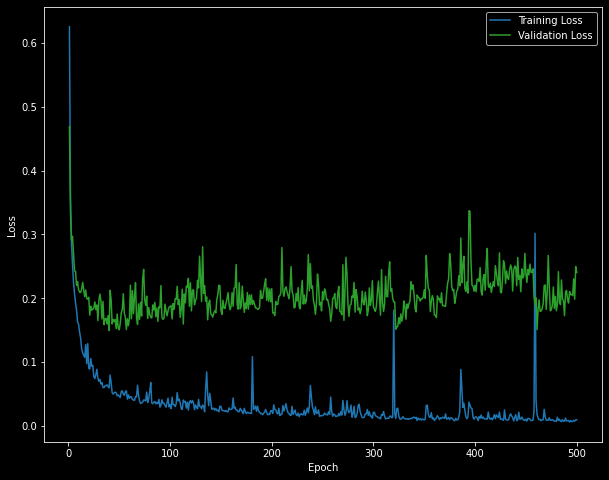

In [14]:
# Let's plot the losses
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(10, 8))

plt.plot(np.arange(1,end_epoch+1,1),
         history.history["loss"], color="tab:blue", label="Training Loss")
plt.plot(np.arange(1,end_epoch+1,1),
         history.history["val_loss"], color="tab:green", label="Validation Loss")

plt.legend()

plt.xlabel("Epoch")
plt.ylabel("Loss")

In [15]:
# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = create_model()

# Compile the model. Since we have one-hot encoded classes we use the categorical crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Show the model summary
model.summary()

# The training won't take long. Let's exceed the number of epochs
end_epoch = 500
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0, 
                    validation_split=0.25,
                    sample_weight=sample_weight,
                    callbacks=[es_callback])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 normalization_1 (Normalizat  (None, 49, 1)            99        
 ion)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 45, 64)            384       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 22, 64)           0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1408)              0         
                                                                 
 dense_2 (Dense)             (None, 15)                2113

In [16]:
# Compute class probabilities
y_test_prop_pred = model.predict(X_test)
print(y_test_prop_pred)

[[9.99560893e-01 1.17445298e-11 2.61867417e-09 4.39048657e-04]
 [1.92206653e-06 3.18419561e-02 9.68155801e-01 3.42211877e-07]
 [5.40253066e-04 1.10853110e-02 8.72004364e-07 9.88373578e-01]
 ...
 [2.10594453e-09 9.99998569e-01 9.61095907e-07 5.00424960e-07]
 [9.99538064e-01 1.37323468e-07 4.26852603e-06 4.57507733e-04]
 [4.13817929e-07 1.14141945e-02 9.88585293e-01 1.69808434e-08]]


In [17]:
# Compute the corresponding one-hot classes
y_test_oh_pred = np.zeros_like(y_test_prop_pred)
y_test_oh_pred[np.arange(len(y_test_prop_pred)), y_test_prop_pred.argmax(1)] = 1
print(y_test_oh_pred)

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]]


In [18]:
# Re-transform the classes now!
asteroid_classes_test = label_encoder.inverse_transform(y_test).reshape(1, -1)[0]
asteroid_classes_test_pred = label_encoder.inverse_transform(y_test_oh_pred).reshape(1, -1)[0]

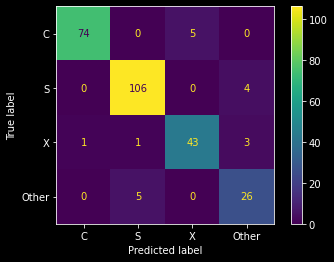

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Compute the confusion matrix
conf_mat = confusion_matrix(asteroid_classes_test,
                            asteroid_classes_test_pred,
                            labels=["C", "S", "X", "Other"])

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                              display_labels=["C", "S", "X", "Other"])
disp.plot()
plt.show()

In [20]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(asteroid_classes_test, asteroid_classes_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.93
